In [53]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

diabetes = load_diabetes()

X_train, X_val, y_train, y_val = train_test_split(diabetes.data, diabetes.target, random_state=0)

model = Ridge(alpha=1e-2).fit(X_train, y_train)

model.score(X_val, y_val)

0.3566606238695452

In [72]:
from sklearn.inspection import permutation_importance

scoring = ['neg_mean_absolute_percentage_error', 'neg_mean_squared_error']

r_multi = permutation_importance(model, X_val, y_val, n_repeats=30, random_state=0, scoring=scoring)

for metric in r_multi:
    print(f"{metric}")
    r = r_multi[metric]
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"    {diabetes.feature_names[i]:<8}"   f"{r.importances_mean[i]:.3f}"   f" +/- {r.importances_std[i]:.3f}")
            #print(r.importances)

neg_mean_absolute_percentage_error
    s5      0.081 +/- 0.020
    bmi     0.064 +/- 0.015
    bp      0.029 +/- 0.010
neg_mean_squared_error
    s5      1013.903 +/- 246.460
    bmi     872.694 +/- 240.296
    bp      438.681 +/- 163.025
    sex     277.382 +/- 115.126


D:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([80])) that is different to the input size (torch.Size([80, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Initial RMSE: 0.5670


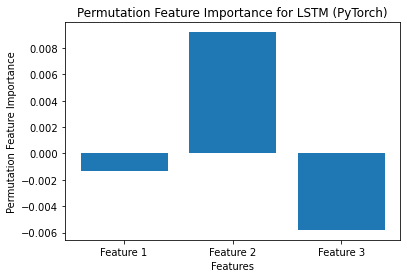

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 生成示例数据
np.random.seed(0)
num_samples = 100
time_steps = 10
num_features = 3
X = np.random.rand(num_samples, time_steps, num_features)
y = np.sum(X, axis=2)[:, -1]  # 简化预测目标，为最后一个时间步特征的和

# 划分数据集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 转换数据为PyTorch张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output, _ = self.lstm(x)
        output = self.fc(output[:, -1, :])
        return output

# 初始化模型、优化器和损失函数
model = LSTMModel(input_size=num_features, hidden_size=50, output_size=1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# 训练模型
num_epochs = 50
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# 计算初始性能
with torch.no_grad():
    y_val_pred = model(X_val_tensor)
    initial_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred.numpy()))
    print(f"Initial RMSE: {initial_rmse:.4f}")

# 计算排列特征重要性
permutation_importances = []
for feature_idx in range(num_features):
    X_val_permuted = X_val.copy()
    np.random.shuffle(X_val_permuted[:, :, feature_idx])
    X_val_permuted_tensor = torch.tensor(X_val_permuted, dtype=torch.float32)
    with torch.no_grad():
        y_val_permuted_pred = model(X_val_permuted_tensor)
        permuted_rmse = np.sqrt(mean_squared_error(y_val, y_val_permuted_pred.numpy()))
        feature_importance = initial_rmse - permuted_rmse
        permutation_importances.append(feature_importance)

# 可视化特征重要性
import matplotlib.pyplot as plt
plt.bar(range(num_features), permutation_importances)
plt.xticks(range(num_features), ['Feature 1', 'Feature 2', 'Feature 3'])
plt.xlabel('Features')
plt.ylabel('Permutation Feature Importance')
plt.title('Permutation Feature Importance for LSTM (PyTorch)')
plt.show()
